In [1]:
from glob import glob
import cv2
import seaborn as sns

sns.set()
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import zipfile

In [2]:
with zipfile.ZipFile("data/train.zip", 'r') as z:
    z.extractall("data")

with zipfile.ZipFile("data/test.zip", 'r') as z:
    z.extractall("data")

In [3]:
HEIGHT, WIDTH = 640, 640

In [4]:
path_train = 'data/train/images/'
path_valid = 'data/valid/images/'
path_test = 'data/images/'

pathes_train = glob(path_train + '*')
pathes_valid = glob(path_valid + '*')
pathes_test = glob(path_test + '*')
# pathes_train = Path(path_train).glob('*.jpg')
# pathes_valid = Path(path_valid).glob('*.jpg')
# pathes_test = Path(path_test).glob('*.jpg')
print(f"train size: {len(pathes_train)}")
print(f"valid size: {len(pathes_valid)}")
print(f"test size: {len(pathes_test)}")

train size: 500
valid size: 99
test size: 401


In [5]:
suf = set()
for p in pathes_train:
    suf.add(Path(p).suffix)
suf

{'.jpg'}

In [6]:
rows = []
for path in pathes_train:
    path = str(path).replace("\\", r"/")
    cur = [path, Path(path).stem]
    rows.append(cur)

train_images = pd.DataFrame(rows, columns=['Path', 'Name'])
train_images.head()

Path  \
0  data/train/images/20200520_194550_01_JPG.rf.59...   
1  data/train/images/20200520_194644_01_JPG.rf.1e...   
2  data/train/images/20200520_194755_01_JPG.rf.6b...   
3  data/train/images/20200520_204821_01_JPG.rf.ee...   
4  data/train/images/20200521_055107_01_JPG.rf.38...   

                                                Name  
0  20200520_194550_01_JPG.rf.595bdd5983267a4f1f44...  
1  20200520_194644_01_JPG.rf.1e08abb4cab5aaf54d10...  
2  20200520_194755_01_JPG.rf.6b24d9bd15a052de6a14...  
3  20200520_204821_01_JPG.rf.ee5c345169f48a0943a5...  
4  20200521_055107_01_JPG.rf.38c155e81f3b8ee52059...

In [7]:
def draw_bounding_boxes(img, boxes, color=(0, 0, 255), t=1):
    for box in boxes:
        x_min, y_min, x_max, y_max = tuple(map(int, box))
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color,
                      thickness=t)


def to_format(coords):
    x_center = coords[0] * HEIGHT
    y_center = coords[1] * WIDTH
    width = coords[2] * WIDTH / 2
    height = coords[3] * HEIGHT / 2
    x_min, y_min = x_center - width, y_center - height
    x_max, y_max = x_center + width, y_center + height
    return list(map(int, (x_min, y_min, x_max, y_max)))


def load_image(path, name='', add_ending=False):
    img_path = path + name
    if add_ending:
        img_path += '.jpg'
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def load_bboxes(path, format="minmax", split=True):
    labels = []
    bboxes = []
    label_and_bbox = []
    with open(path, 'r') as f:
        for row in f:
            row = tuple(map(float, row.split()))
            class_name, box = row[0], row[1:]
            if format == "minmax":
                box = to_format(box)
            labels.append(class_name)
            bboxes.append(box)
            label_and_bbox.append([class_name, *box])
    if split:
        return labels, bboxes
    else:
        return label_and_bbox


def draw_sample_images(n=4, color=(0, 0, 255), t=1):
    path_label = glob('data/train/labels/*')

    indexes = np.random.randint(0, len(pathes_train), n)
    sample_images = [load_image(pathes_train[i]) for i in indexes]
    sample_labels = [load_bboxes(path_label[i])[1] for i in indexes]

    fig = plt.figure(figsize=(16, 16))
    k_axes = int(np.ceil(np.sqrt(n)))

    for i, img in enumerate(sample_images):
        fig.add_subplot(k_axes, k_axes, i + 1)
        draw_bounding_boxes(img, sample_labels[i], color=color, t=t)
        plt.imshow(img)
        plt.title(f"seagull count: {len(sample_labels[i])}")

    plt.show()


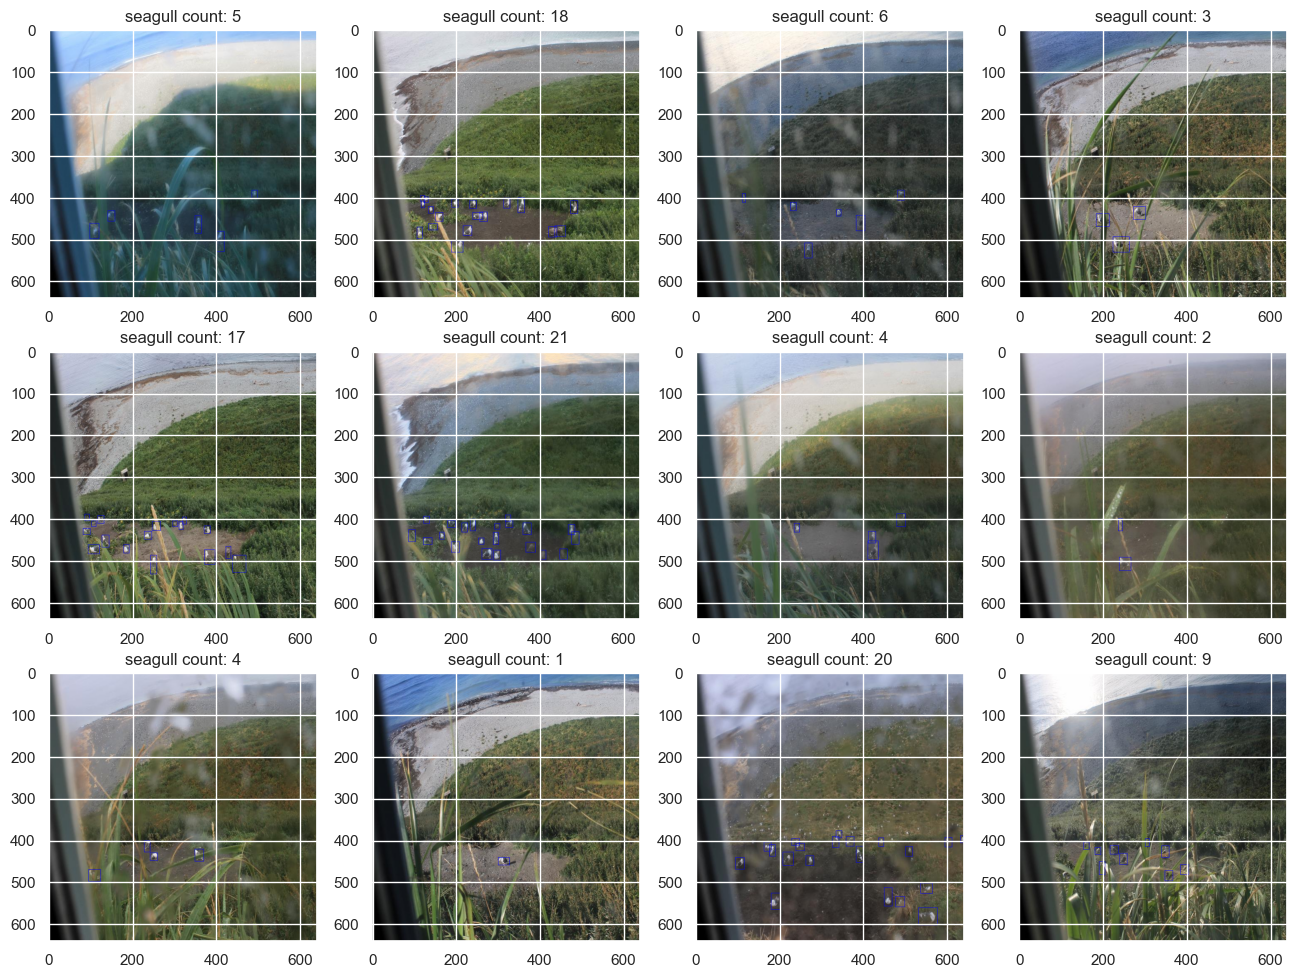

In [8]:
 draw_sample_images(n=12)

In [28]:
columun_names = ['im_name', 'labels_path', 'width', 'height', 'square', 'x_min',
                 'y_min', 'x_max', "y_max", "x_yolo", "y_yolo", "w_yolo", "h_yolo"]

pathes = Path('data/train/labels').glob("*.txt")

list_row = []
for path in pathes:
    path = Path(path)
    name = Path(path).stem
    with path.open('r') as f:
        count = 0
        for count, row in enumerate(f):
            row = list(map(float, row.split()))
            coords = to_format(row[1:])
            w, h = row[3] * WIDTH, row[4] * HEIGHT
            cur = [name, path, w, h, w * h, *coords, *row[1:]]
            list_row.append(cur)

        if count == 0:
            cur = [name, path]
            for _ in range(len(columun_names) - 2): cur.append(np.nan)
            list_row.append(cur)

seagulls = pd.DataFrame(list_row, columns=columun_names)
print(seagulls.im_name.nunique())
seagulls.head()

1000


im_name  \
0  !trans0_20200520_194550_01_JPG.rf.595bdd598326...   
1  !trans0_20200520_194644_01_JPG.rf.1e08abb4cab5...   
2  !trans0_20200520_194755_01_JPG.rf.6b24d9bd15a0...   
3  !trans0_20200520_204821_01_JPG.rf.ee5c345169f4...   
4  !trans0_20200520_204821_01_JPG.rf.ee5c345169f4...   

                                         labels_path  width  height  square  \
0  data\train\labels\!trans0_20200520_194550_01_J...    NaN     NaN     NaN   
1  data\train\labels\!trans0_20200520_194644_01_J...    NaN     NaN     NaN   
2  data\train\labels\!trans0_20200520_194755_01_J...    NaN     NaN     NaN   
3  data\train\labels\!trans0_20200520_204821_01_J...   24.0    24.0   576.0   
4  data\train\labels\!trans0_20200520_204821_01_J...   35.5    23.0   816.5   

   x_min  y_min  x_max  y_max    x_yolo    y_yolo    w_yolo    h_yolo  
0    NaN    NaN    NaN    NaN       NaN       NaN       NaN       NaN  
1    NaN    NaN    NaN    NaN       NaN       NaN       NaN       NaN  
2    NaN    NaN    NaN    NaN       NaN       NaN       NaN       NaN  
3  478.0  501.0  502.0  525.0  0.767187  0.802344  0.037500  0.037500  
4  474.0  521.0  509.0  544.0  0.768750  0.832031  0.055469  0.035937

[<Axes: > <Axes: > <Axes: >]


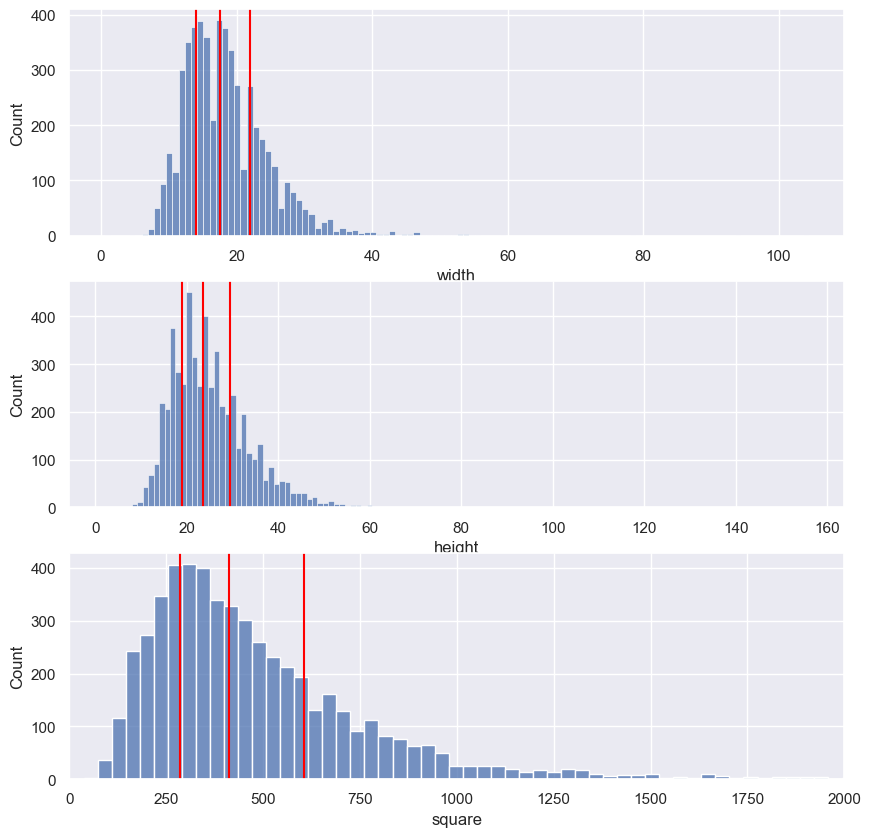

In [10]:
fig, ax = plt.subplots(nrows=3, figsize=(10, 10))
quantiles = ['25%', '50%', '75%']
print(ax)
sns.histplot(seagulls.width, ax=ax[0])
desc = seagulls["width"].describe()
for i in range(len(quantiles)):
    ax[0].axvline(desc[quantiles[i]], color="red")

plt.xlim((0, 100))
sns.histplot(seagulls.height, ax=ax[1])
desc = seagulls["height"].describe()
for i in range(len(quantiles)):
    ax[1].axvline(desc[quantiles[i]], color="red")

plt.xlim((0, 2000))
sns.histplot(seagulls.square, ax=ax[2])
desc = seagulls["square"].describe()
for i in range(len(quantiles)):
    ax[2].axvline(desc[quantiles[i]], color="red")

plt.show()


In [11]:
seagulls.sort_values(by='im_name', ascending=False)

im_name  \
5443  20200928_120415_01_JPG.rf.a8d793aadaccbe4c5628...   
5442  20200928_100340_01_JPG.rf.71953f6ead79f0efe8e9...   
5441  20200928_090324_01_JPG.rf.705ca918a229a464994c...   
5440  20200928_090324_01_JPG.rf.705ca918a229a464994c...   
5439  20200928_090324_01_JPG.rf.705ca918a229a464994c...   
...                                                 ...   
29    20200520_204821_01_JPG.rf.ee5c345169f48a0943a5...   
3     20200520_204821_01_JPG.rf.ee5c345169f48a0943a5...   
2     20200520_194755_01_JPG.rf.6b24d9bd15a052de6a14...   
1     20200520_194644_01_JPG.rf.1e08abb4cab5aaf54d10...   
0     20200520_194550_01_JPG.rf.595bdd5983267a4f1f44...   

                                            labels_path  width  height  \
5443  data\train\labels\20200928_120415_01_JPG.rf.a8...    NaN     NaN   
5442  data\train\labels\20200928_100340_01_JPG.rf.71...    NaN     NaN   
5441  data\train\labels\20200928_090324_01_JPG.rf.70...   14.5    22.5   
5440  data\train\labels\20200928_090324_01_JPG.rf.70...   12.0    27.5   
5439  data\train\labels\20200928_090324_01_JPG.rf.70...   15.5    21.5   
...                                                 ...    ...     ...   
29    data\train\labels\20200520_204821_01_JPG.rf.ee...   18.5    33.5   
3     data\train\labels\20200520_204821_01_JPG.rf.ee...   24.0    24.0   
2     data\train\labels\20200520_194755_01_JPG.rf.6b...    NaN     NaN   
1     data\train\labels\20200520_194644_01_JPG.rf.1e...    NaN     NaN   
0     data\train\labels\20200520_194550_01_JPG.rf.59...    NaN     NaN   

      square  x_min  y_min  x_max  y_max    x_yolo    y_yolo    w_yolo  \
5443     NaN    NaN    NaN    NaN    NaN       NaN       NaN       NaN   
5442     NaN    NaN    NaN    NaN    NaN       NaN       NaN       NaN   
5441  326.25  213.0  409.0  227.0  431.0  0.344531  0.657031  0.022656   
5440  330.00  152.0  409.0  164.0  436.0  0.246875  0.660937  0.018750   
5439  333.25  476.0  402.0  491.0  424.0  0.756250  0.646094  0.024219   
...      ...    ...    ...    ...    ...       ...       ...       ...   
29    619.75  307.0  287.0  325.0  320.0  0.494531  0.475000  0.028906   
3     576.00  137.0  501.0  161.0  525.0  0.232813  0.802344  0.037500   
2        NaN    NaN    NaN    NaN    NaN       NaN       NaN       NaN   
1        NaN    NaN    NaN    NaN    NaN       NaN       NaN       NaN   
0        NaN    NaN    NaN    NaN    NaN       NaN       NaN       NaN   

        h_yolo  
5443       NaN  
5442       NaN  
5441  0.035156  
5440  0.042969  
5439  0.033594  
...        ...  
29    0.052344  
3     0.037500  
2          NaN  
1          NaN  
0          NaN  

[5444 rows x 13 columns]

In [12]:
to_drop = seagulls[(seagulls.height > 100) | (seagulls.width > 100) | (
        seagulls.height <= 5) | (seagulls.width <= 5)]
print(to_drop.im_name.nunique())
to_drop = to_drop.sort_values(by=["height", "im_name"], ascending=False)

5


In [13]:
name_box_to_drop = {}
for i, row in to_drop.iterrows():
    path = path_train + row[0] + '.jpg'
    if path not in name_box_to_drop:
        name_box_to_drop[path] = []

    name_box_to_drop[path].append(list(row[-8:-4].values))

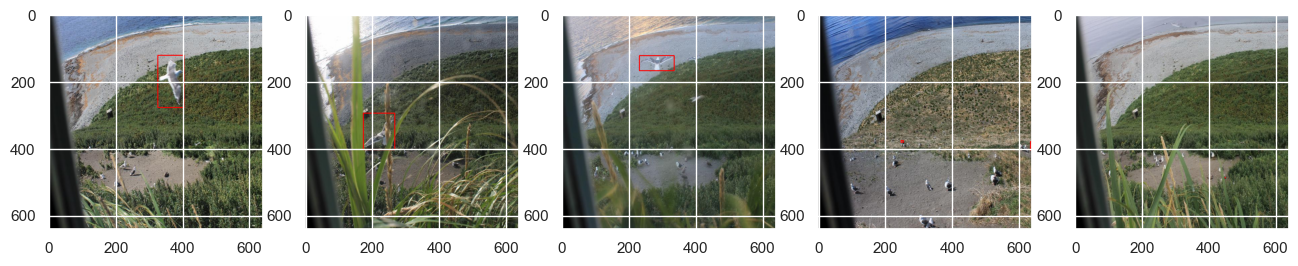

In [14]:

fig = plt.figure(figsize=(16, 16))

for i, (name, boxes) in enumerate(name_box_to_drop.items()):

    if i >= 16: break
    fig.add_subplot(3, 5, i + 1)
    img = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB)
    draw_bounding_boxes(img, boxes, color=(255, 0, 0), t=2)
    plt.imshow(img)

plt.show()

In [15]:
name_box_dict = {}
for i, row in seagulls.iterrows():
    path = path_train + row[0] + '.jpg'
    if path not in name_box_dict:
        name_box_dict[path] = []
    if not np.isnan(row[-1]):
        name_box_dict[path].append(list(row[-4:].values))

In [42]:
import albumentations as A

transform1 = A.Compose(
    [
        # COLOR TRANFORMATIONS --------------
        A.augmentations.transforms.ColorJitter(p=0.1),
        A.augmentations.transforms.Sharpen(p=0.1),
        A.augmentations.transforms.ToGray(p=0.1),
        A.RandomBrightnessContrast(p=0.7),

        # A.augmentations.HorizontalFlip(p=0.5),
        # # flip image on its vertical axis
        # A.Affine(
        #     translate_percent=0.1,
        #     rotate=4,
        #     shear=2,
        #     scale=(0.9, 1.1),
        #     mode=0,
        #     cval=(114, 114, 114),
        #     p=0.9
        # ),
        # A.ImageCompression(quality_lower=50, p=0.1),
        # A.LongestMaxSize(HEIGHT),
        # A.PadIfNeeded(WIDTH, HEIGHT, border_mode=0, value=(114, 114, 114)),
    ],
    bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'],
                             min_visibility=0.6),  # COCO: source format
)

In [17]:
#NOT USING
transform2 = A.Compose([
    A.RandomContrast(p=0.5),
    A.RandomBrightness(p=0.5),
], bbox_params=A.BboxParams(format='yolo', min_visibility=0.6,
                            label_fields=['class_labels']))

C:\Users\avear\PycharmProjects\Seagull_count_hakaton\venv\Lib\site-packages\albumentations\augmentations\transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
C:\Users\avear\PycharmProjects\Seagull_count_hakaton\venv\Lib\site-packages\albumentations\augmentations\transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [18]:
train_images.head()

Path  \
0  data/train/images/20200520_194550_01_JPG.rf.59...   
1  data/train/images/20200520_194644_01_JPG.rf.1e...   
2  data/train/images/20200520_194755_01_JPG.rf.6b...   
3  data/train/images/20200520_204821_01_JPG.rf.ee...   
4  data/train/images/20200521_055107_01_JPG.rf.38...   

                                                Name  
0  20200520_194550_01_JPG.rf.595bdd5983267a4f1f44...  
1  20200520_194644_01_JPG.rf.1e08abb4cab5aaf54d10...  
2  20200520_194755_01_JPG.rf.6b24d9bd15a052de6a14...  
3  20200520_204821_01_JPG.rf.ee5c345169f48a0943a5...  
4  20200521_055107_01_JPG.rf.38c155e81f3b8ee52059...

In [ ]:
trans_path = Path("data/train/trans")


def save_image(path, img, prefix="!trans_", img_name=None):
    path = Path(path)
    if img_name is None:
        img_name = path.name
    path = Path(path).parents[0] / Path(prefix + img_name)
    cv2.imwrite(str(path), img)


def save_bboxes(path, bboxes, labels, prefix=""):
    path = Path(path)
    file_name = Path(prefix + str(path.stem) + '.txt')
    path = Path(path).parents[1] / "labels" / file_name
    to_write = []

    for l, box in zip(labels, bboxes):
        cur = [str(l)]
        for x in box:
            cur.append(str(x))
        s = " ".join(cur)
        s += '\n'
        to_write.append(s)

    with path.open('w') as f:
        f.writelines(to_write)


def transform_images(df):
    transformers = [transform1]

    def to_apply(im_path):
        try:
            bboxes = name_box_dict[im_path]
            img = load_image(im_path)
            for i, trans in enumerate(transformers):
                transformed = trans(image=img, bboxes=bboxes,
                                    class_labels=[0 for _ in
                                                  range(len(bboxes))])
                train_images._append([im_path, Path(im_path).name])
                plt.imshow(transformed['image'])
                save_image(im_path, transformed['image'], prefix=f"!trans{i}_")
                save_bboxes(im_path, transformed['bboxes'],
                            transformed['class_labels'], prefix=f"!trans{i}_")

        except KeyError:
            print(f"KeyError, file {im_path} is not found")

    df.Path.apply(to_apply)

rows = []
for path in pathes_valid:
    path = str(path).replace("\\", r"/")
    cur = [path, Path(path).stem]
    rows.append(cur)

valid_images = pd.DataFrame(rows, columns=['Path', 'Name'])
valid_images.head()

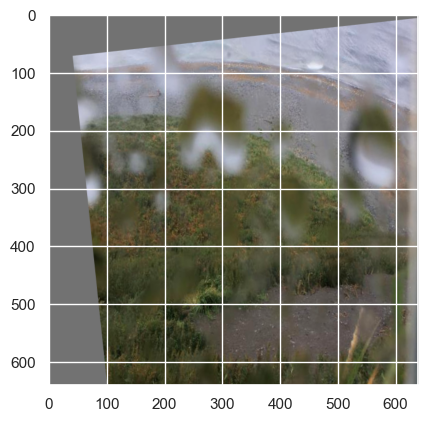

In [26]:
transform_images(train_images)

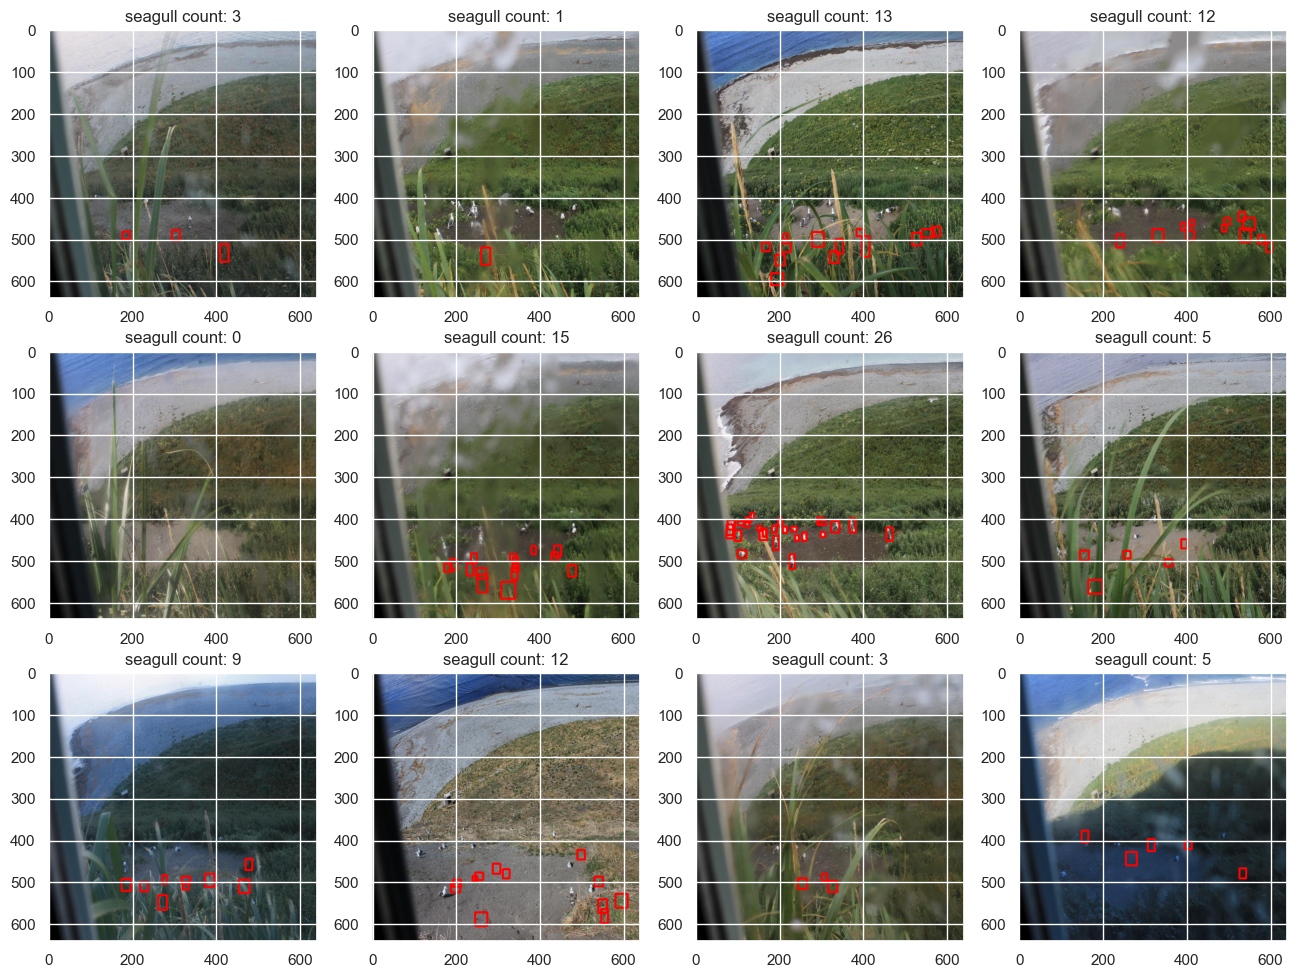

In [22]:
draw_sample_images(n=12, color=(255, 0, 0), t=3)

[[448, 445, 468, 474], [359, 506, 392, 535], [447, 511, 460, 534], [237, 449, 252, 480], [230, 450, 253, 477], [242, 477, 257, 499], [517, 504, 543, 539], [585, 477, 609, 520], [586, 448, 603, 476]]


[[448, 445, 468, 474], [359, 506, 392, 535], [447, 511, 460, 534], [237, 449, 252, 480], [230, 450, 253, 477], [242, 477, 257, 499], [517, 504, 543, 539], [585, 477, 609, 520], [586, 448, 603, 476]]


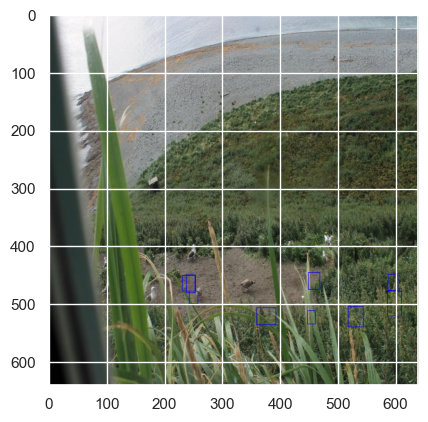

In [62]:
i = np.random.randint(0, len(pathes_train), 1)[0]
img = load_image(pathes_train[i])
path_label = glob('data/train/labels/*')
bbox = load_bboxes(path_label[i], format='yolo')[1]
print([to_format(b) for b in bbox])
transformed = transform1(image=img, bboxes=bbox,
                         class_labels=[0 for _ in range(len(bbox))])

img = transformed["image"]
bbox = [to_format(b) for b in transformed['bboxes']]
print()
print()

print(bbox)
draw_bounding_boxes(img, bbox)
plt.imshow(img)